# Recognizing the faces

Just here, we've extract the features of images and trained the model. From this moment, we're able to recognize the faces. To test the model, we consider a total of ten images that contain just one person and images with more than one person.

## Importing Libraries

In [1]:
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
from imutils import paths
import matplotlib.pyplot as plt
from imutils.video import VideoStream
from imutils.video import FPS
import time

## Loading the pre-trained models

For this example, we need to consider three pre-trained model to realize the face detection, the embedding and the face recognition.

In [2]:
# Setting the face detector
protoPath = os.path.sep.join(["input", "deploy.prototxt.txt"])
modelPath = os.path.sep.join(["input", "res10_300x300_ssd_iter_140000.caffemodel"])
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

In [3]:
# Setting the pre trained FaceNet model
embedder = cv2.dnn.readNetFromTorch("input/nn4.small2.v1.t7")

In [4]:
# load the face recognition model
recognizer = pickle.loads(open("output/recognizer1.pickle", "rb").read())
le = pickle.loads(open("output/le1.pickle", "rb").read())

In [5]:
img_test_Paths = list(paths.list_images("images"))
len(img_test_Paths)

10

## Recognizing the faces

To recognize the faces we need to do
- Read and preprocessing the image
- Extract the blobs (another image preprocessing) and make prediction
- From the predictions we extract the ROI and crop it
- With the cropped image we extract the embedding vector
- With the feature vector we realize the face recognition.

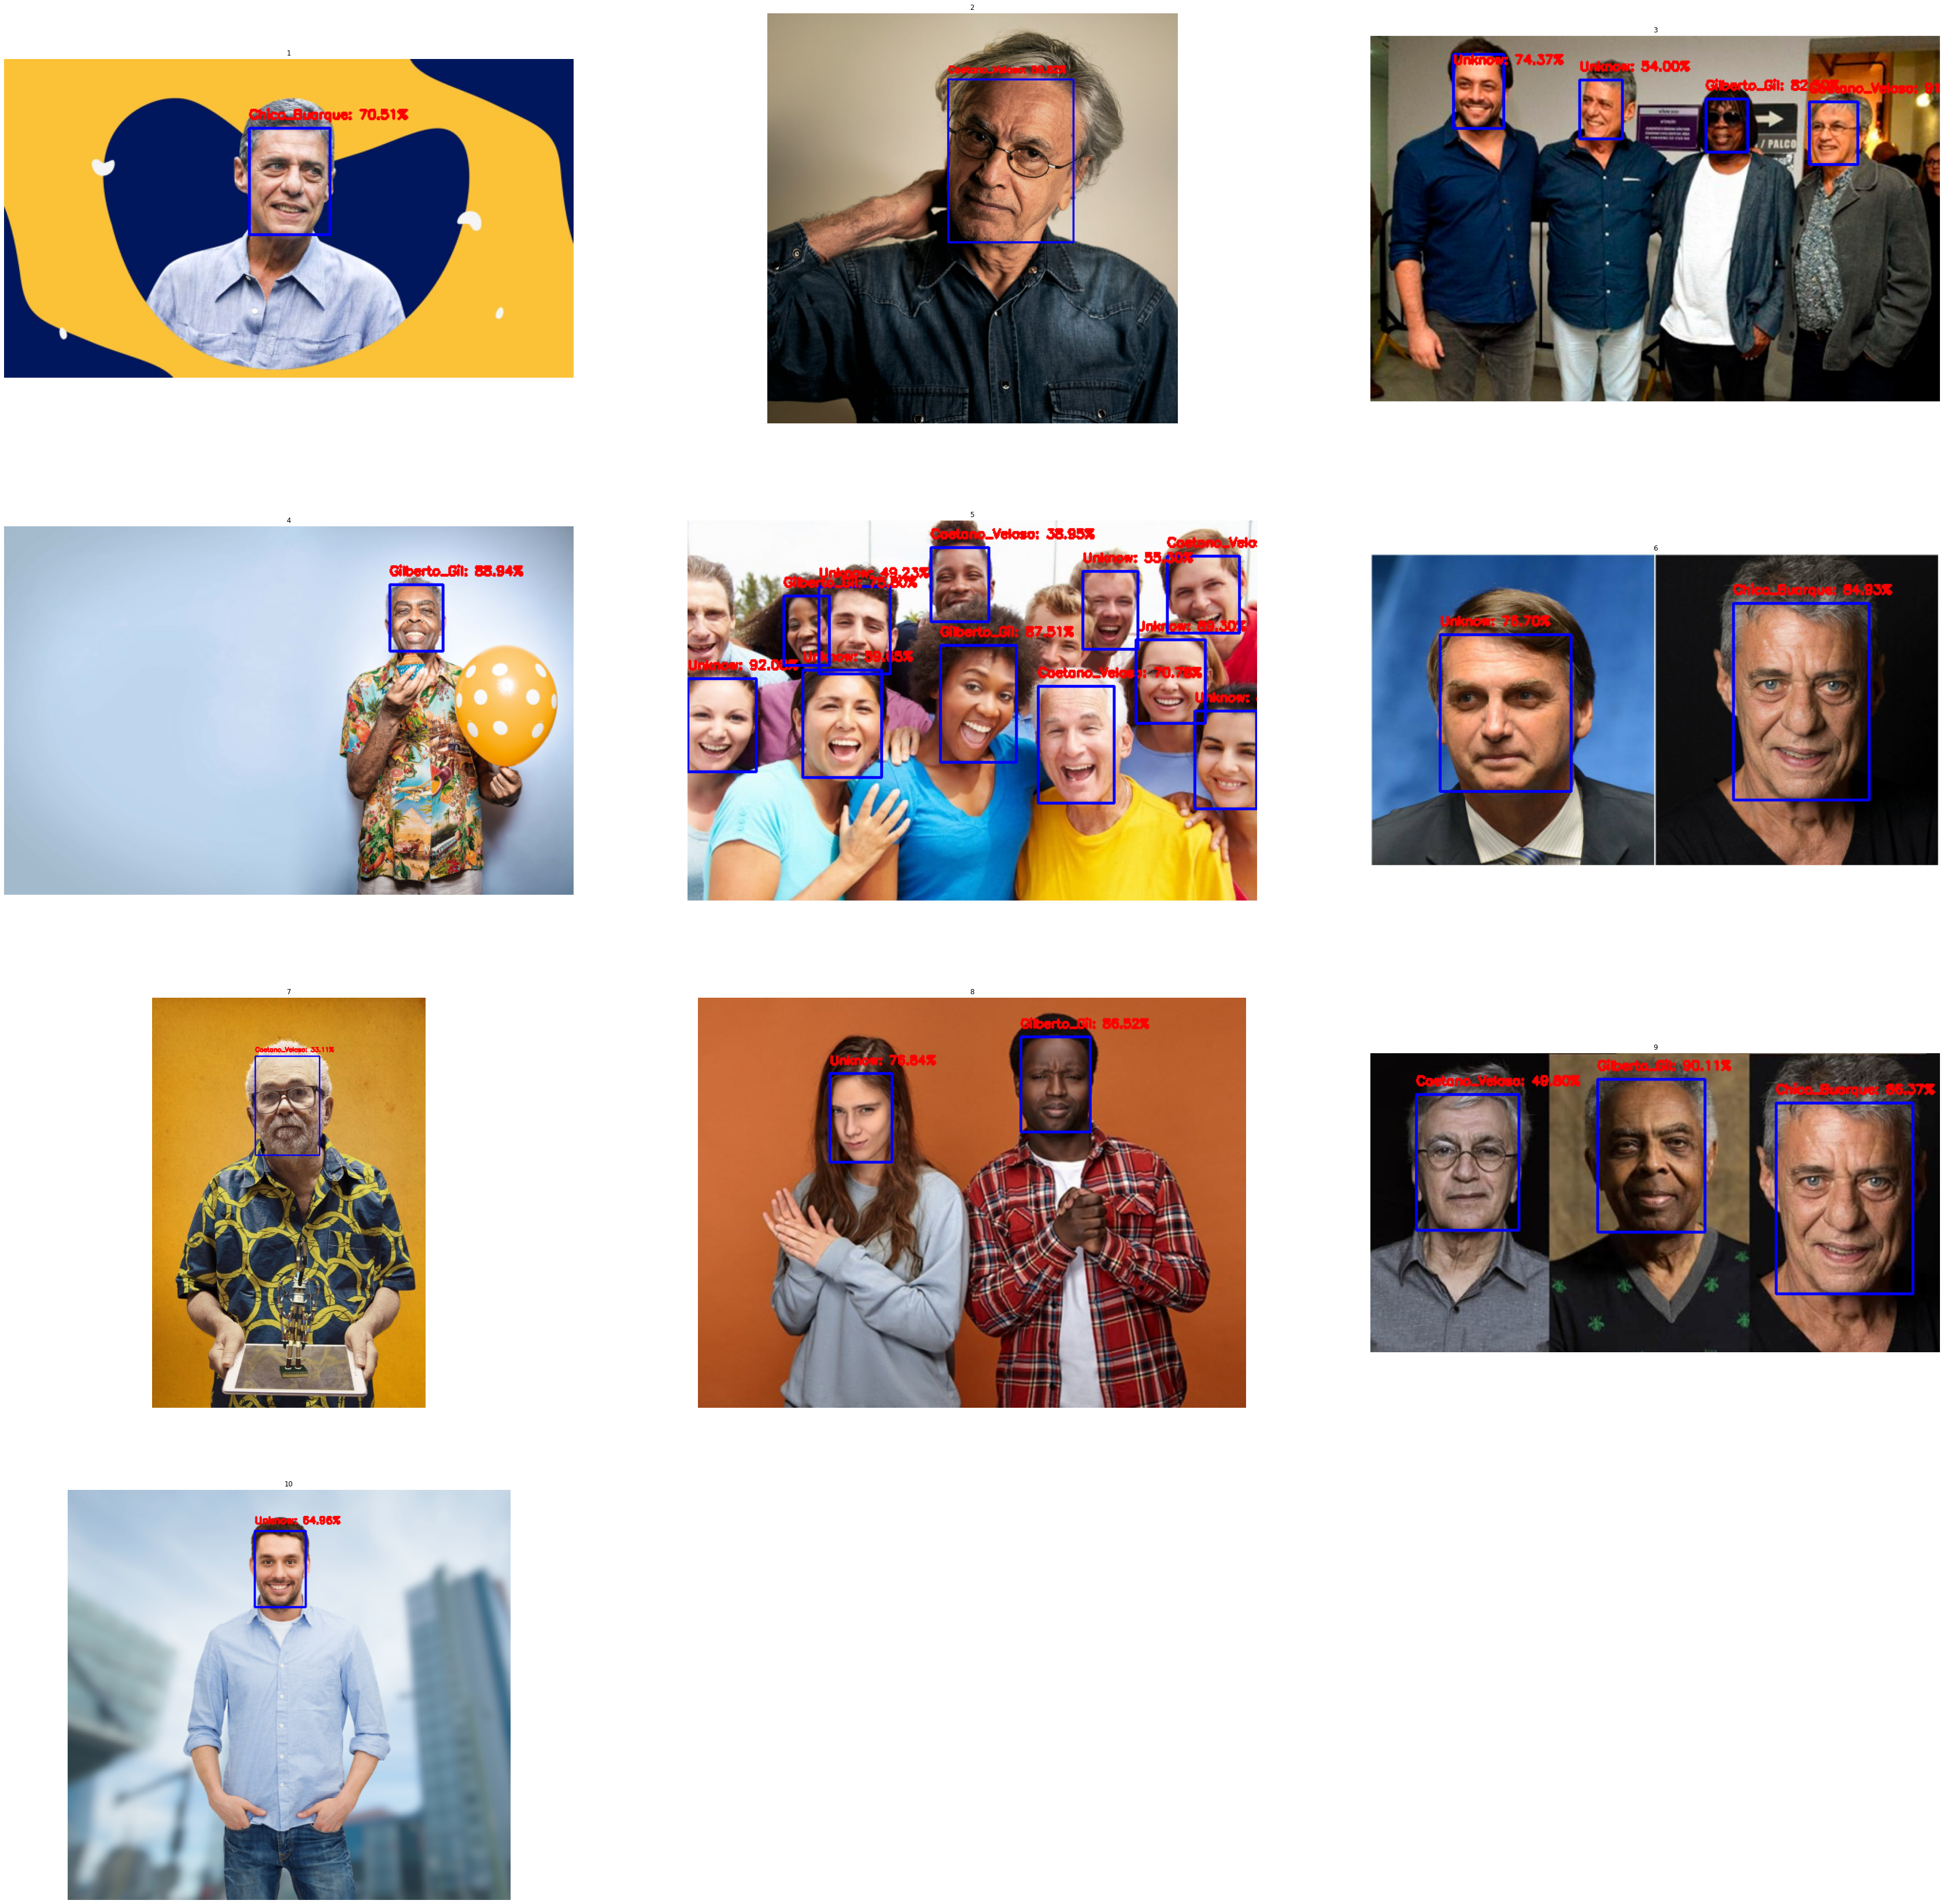

In [6]:
plt.figure(figsize=(60, 60))
count = 1
for img in img_test_Paths:
    image = cv2.imread(img)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
# construct a blob from the image
    imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),
                                  (104.0, 177.0, 123.0), swapRB=False, crop=False)
# apply OpenCV's deep learning-based face detector to localize
# faces in the input image
    detector.setInput(imageBlob)
    detections = detector.forward()

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the
        # prediction
        confidence = detections[0, 0, i, 2]
        # filter out weak detections
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for the
            # face
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # extract the face ROI
            face = image[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]
            # ensure the face width and height are sufficiently larg
            if fW < 20 or fH < 20:
                continue
            # construct a blob for the face ROI, then pass the blob
            # through our face embedding model to obtain the 128-d
            # quantification of the face
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
                                             (0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()
            # perform classification to recognize the face
            preds = recognizer.predict_proba(vec)[0]
            j = np.argmax(preds)
            proba = preds[j]
            name = le.classes_[j]
            # draw the bounding box of the face along with the associated
            # probability
            text = "{}: {:.2f}%".format(name, proba * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(image, (startX, startY), (endX, endY),
                          (255, 0, 0), 2)
            cv2.putText(image, text, (startX, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    ax = plt.subplot(4, 3, count)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("{:d}".format(count))
    plt.axis("off")
    count += 1
    # show the output image
plt.savefig("output/recognitions.jpg")
plt.show()


## Conclusion

After three steps, we have our recognizer engine. As we've said in the previous step, the ideal is to deploy a quickly model. We can see from the images that our model has a certain level of accuracy, this is not a perfect model. We have 9 faces of the Brazilian singers in the test set, just one had a false negative result, in the image 3. The problem of false prediction is more evident over the unknown class. The image 5, for example, we have a total of 11 predictions, 6 true positives and 5 false negative. We can also see that some characteristic as hair or skin color have an effect over the predictions. In general, our model is $60\%$ accurate.

How to improve the performance? Getting more dataset, using technical of image preprocessing as face alignment. Inside the main folder Face Recognition, we present also a model using dlib and facenet, this model is more accurate due to the image preprocessing embedded on the libraries.